<a href="https://colab.research.google.com/github/AbdoAlkayal/Machine_Learning/blob/main/TwitterSentimentAnalysis(LSTM_RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, losses, optimizers
import pandas as pd
import zipfile
import random
from sklearn.model_selection import train_test_split


In [2]:
from google.colab import files
uploaded = files.upload()

Saving training.csv to training.csv


In [3]:
print(uploaded.keys())

dict_keys(['training.csv'])


In [4]:
import io
# Replace with correct encoding
df = pd.read_csv(io.BytesIO(uploaded['training.csv']), encoding='latin-1')
df

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [5]:

df.columns = ['target', 'id', 'date', 'query', 'user', 'text']
# Use only text and sentiment
df = df[['target', 'text']]
df['target'] = df['target'].apply(lambda x: 1 if x == 4 else 0)

<ipython-input-5-9afc8ed2ea9e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['target'].apply(lambda x: 1 if x == 4 else 0)


In [6]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['text'], df['target'], test_size=0.2, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
# Prepare TensorFlow datasets
def prepare_ds(texts, labels):
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    ds = ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = prepare_ds(train_texts.values, train_labels.values)
val_ds = prepare_ds(val_texts.values, val_labels.values)
test_ds = prepare_ds(test_texts.values, test_labels.values)

In [8]:
print("Number of training samples:", len(train_texts))
print("Number of validation samples:", len(val_texts))
print("Number of testing samples:", len(test_texts))


Number of training samples: 1279999
Number of validation samples: 160000
Number of testing samples: 160000


In [9]:
for texts, labels in train_ds.take(1):
    print("🔹 Train Set Sample")
    print("Texts:", texts.numpy()[:3])  # Show first 3 tweets
    print("Labels:", labels.numpy()[:3])
    print()

for texts, labels in val_ds.take(1):
    print("🔹 Validation Set Sample")
    print("Texts:", texts.numpy()[:3])
    print("Labels:", labels.numpy()[:3])
    print()

for texts, labels in test_ds.take(1):
    print("🔹 Test Set Sample")
    print("Texts:", texts.numpy()[:3])
    print("Labels:", labels.numpy()[:3])

🔹 Train Set Sample
Texts: [b'@nickvanna see you tonight! '
 b"Got out of work near 10 minutes late. I know it could be worse, but that's 10 minutes of my weekend I'll never get back. "
 b"@kaylashearer Haha! Nope, just the tinyurl's in general "]
Labels: [1 0 1]

🔹 Validation Set Sample
Texts: [b"i guess it just doesn't last forever...what could I expect? adoro-te miga e tu sabes "
 b"@TheDailyBlonde Sorry to hear of your friends mother's passing. "
 b'gooood morning   I love sleeping in ']
Labels: [1 0 1]

🔹 Test Set Sample
Texts: [b'@chittabug I hope u r doing better now sweetheart. I hate seeing u down and out like u have been feeling lately  I wish I could hug u now'
 b'@catagator As a 23 year old, this makes me feel VERY cool '
 b"@angelbear7 I'm good! Up way past my bedtime, though. It's almost 2AM EST.  I'm sure my lovely wife would like me in bed. You?"]
Labels: [0 1 0]


In [10]:
VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 100

vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_sequence_length=SEQUENCE_LENGTH)

vectorizer.adapt(train_texts.values)

In [11]:
vocab = np.array(vectorizer.get_vocabulary())
vocab[:30]

array(['', '[UNK]', 'i', 'to', 'the', 'a', 'my', 'and', 'you', 'is', 'it',
       'for', 'in', 'of', 'im', 'on', 'me', 'so', 'have', 'that', 'but',
       'just', 'with', 'be', 'at', 'its', 'not', 'was', 'this', 'now'],
      dtype='<U27')

In [12]:
def build_model(rnn_type='SimpleRNN'):
    model = tf.keras.Sequential([
        vectorizer,
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, mask_zero=True),
        tf.keras.layers.SimpleRNN(64) if rnn_type == 'SimpleRNN' else tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    return model

In [13]:
def train_and_evaluate(rnn_type):
    model = build_model(rnn_type)
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(1e-4),
        metrics=['accuracy']
    )

    print(f"Training {rnn_type} model...")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=3,steps_per_epoch=1000,validation_steps=100
    )

    test_loss, test_acc = model.evaluate(test_ds)
    return history, test_loss, test_acc

In [14]:
rnn_history, rnn_loss, rnn_acc = train_and_evaluate('SimpleRNN')
lstm_history, lstm_loss, lstm_acc = train_and_evaluate('LSTM')

Training SimpleRNN model...
Epoch 1/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 172s 165ms/step - accuracy: 0.5576 - loss: 0.6542 - val_accuracy: 0.7395 - val_loss: 0.5118
Epoch 2/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 165s 165ms/step - accuracy: 0.7502 - loss: 0.4956 - val_accuracy: 0.7619 - val_loss: 0.4750
Epoch 3/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 201s 201ms/step - accuracy: 0.7685 - loss: 0.4697 - val_accuracy: 0.7811 - val_loss: 0.4584
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 107s 43ms/step - accuracy: 0.7756 - loss: 0.4534
Training LSTM model...
Epoch 1/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5726 - loss: 0.6360 - val_accuracy: 0.7575 - val_loss: 0.4947
Epoch 2/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7592 - loss: 0.4863 - val_accuracy: 0.7700 - val_loss: 0.4726
Epoch 3/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7712 - loss: 0.4695 - val_accuracy: 0.7802 - val_loss: 0.4645
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7814 - loss: 0.4569


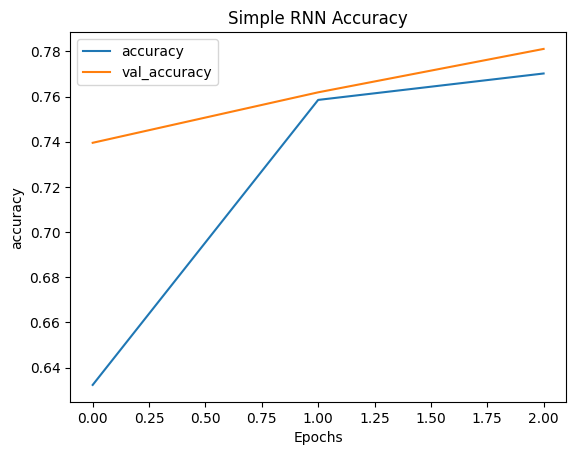

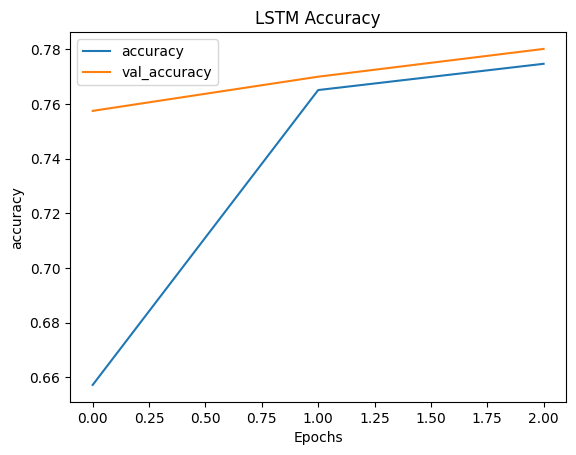

In [17]:
def plot_graphs(history, metric, title):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(title)
    plt.legend([metric, 'val_'+metric])
    plt.show()

plot_graphs(rnn_history, 'accuracy', 'Simple RNN Accuracy')
plot_graphs(lstm_history, 'accuracy', 'LSTM Accuracy')

In [18]:
import pandas as pd

results = pd.DataFrame([
    {"Model": "Simple RNN", "Test Loss": round(rnn_loss, 4), "Test Accuracy": round(rnn_acc, 4)},
    {"Model": "LSTM", "Test Loss": round(lstm_loss, 4), "Test Accuracy": round(lstm_acc, 4)},
])

print(results)

        Model  Test Loss  Test Accuracy
0  Simple RNN     0.4538         0.7751
1        LSTM     0.4577         0.7807
